In [118]:
from deuces import Card
from deuces import Evaluator
evaluator = Evaluator()

from deuces import Deck
deck = Deck()
board = deck.draw(5)
player1_hand = deck.draw(2)
player2_hand = deck.draw(2)

Card.print_pretty_cards(board)
Card.print_pretty_cards(player1_hand)
Card.print_pretty_cards(player2_hand)

p1_score = evaluator.evaluate(board, player1_hand)
p2_score = evaluator.evaluate(board, player2_hand)
p1_class = evaluator.get_rank_class(p1_score)
p2_class = evaluator.get_rank_class(p2_score)

print("Player 1 hand rank = %d (%s)\n" % (p1_score, evaluator.class_to_string(p1_class)))
print("Player 2 hand rank = %d (%s)\n" % (p2_score, evaluator.class_to_string(p2_class)))


  [ 7 ♣ ] , [ 6 ♣ ] , [ A ♦ ] , [ J ♣ ] , [ T ♣ ]  
  [ 8 ♣ ] , [ 2 ♠ ]  
  [ 3 ♦ ] , [ K ❤ ]  
Player 1 hand rank = 1374 (Flush)

Player 2 hand rank = 6232 (High Card)



In [119]:
hands = [player1_hand, player2_hand]
evaluator.hand_summary(board, hands)

========== FLOP ==========
Player 1 hand = High Card, percentage rank among all hands = 0.109086
Player 2 hand = High Card, percentage rank among all hands = 0.151434
Player 2 hand is currently winning.

========== TURN ==========
Player 1 hand = High Card, percentage rank among all hands = 0.126374
Player 2 hand = High Card, percentage rank among all hands = 0.162289
Player 2 hand is currently winning.

========== RIVER ==========
Player 1 hand = Flush, percentage rank among all hands = 0.815867
Player 2 hand = High Card, percentage rank among all hands = 0.164835

========== HAND OVER ==========
Player 1 is the winner with a Flush



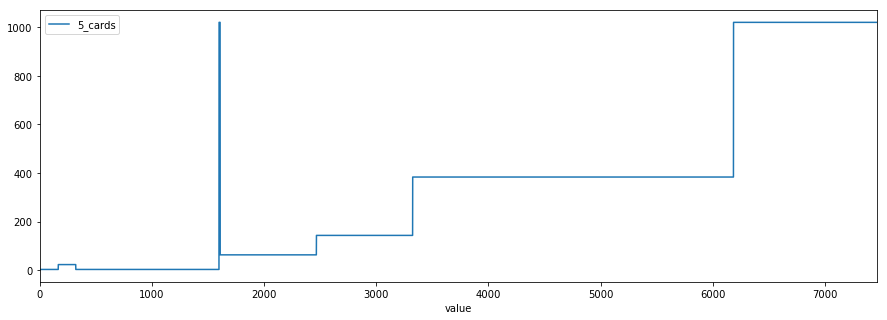

In [120]:
# plot equivalence classes
import matplotlib.pyplot as plt
import pandas as pd

equiv_classes = pd.read_csv(
    'equivalence_classes.csv',
    sep=',',
    header=None,
    names=[
        'value',
        '5_cards',
        '6_cards',
        '7_cards',
        '8_cards',
        'sample',
        'abbrev',
        'description'
    ]
)

%matplotlib inline

# Stop plots overwriting each other
plt.ioff()  
df = equiv_classes[['value', '5_cards']].set_index('value')

df.plot(figsize=(15, 5))

In [121]:
def build_dataframe(nb_hands=100, nb_players=2):
    decks = [ Deck() for _ in range(nb_hands) ]

    df_board = pd.DataFrame({
        'board': [ deck.draw(5) for deck in decks ]
    })

    df_players = pd.concat(
        [
            pd.DataFrame({
                'player': [ deck.draw(2) for deck in decks ]
            })
            for _ in range(nb_players)
        ],
        axis=1,
        keys=range(nb_players)
    )
    df_players = df_players.swaplevel(0, 1, axis=1)

    evaluator = Evaluator()
    df_scores = pd.concat(
        [
            df_board.join(df_players.xs(i, level=1, axis=1)).apply(
                lambda x: evaluator.evaluate(x['board'], x['player']),
                axis=1
            ).to_frame('score')
            for i in df_players.columns.get_level_values(1)
        ],
        axis=1,
        keys=df_players.columns.get_level_values(1)
    )
    df_scores = df_scores.swaplevel(0, 1, axis=1)

    return df_board, df_players, df_scores

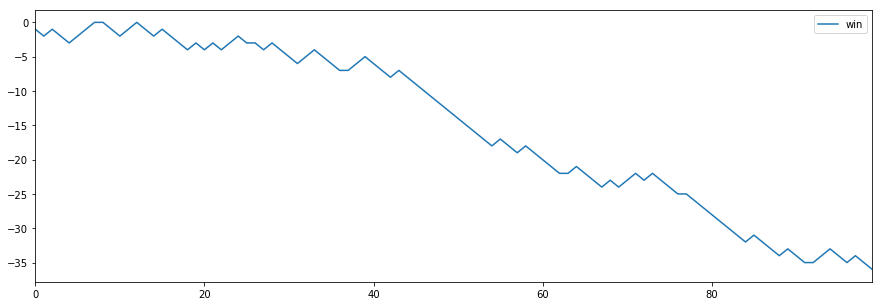

In [122]:
# pnl chart
import random

random.seed(0)
_, _, df_scores = build_dataframe(nb_players=5)
df_scores.columns = df_scores.columns.get_level_values(1)

df = pd.concat(
    [
        df_scores[[0]],
        df_scores[[1]].min(axis=1),
        df_scores[[1, 2]].min(axis=1),
        df_scores[[1, 2, 3]].min(axis=1),
        df_scores[[1, 2, 3, 4]].min(axis=1)
    ],
    axis = 1,
    keys = range(5)
)
df.columns = df.columns.get_level_values(0)

df['win'] = df[2] - df[0]

df.ix[df.win!=0, 'win'] = df.ix[df.win!=0, 'win'] / df.ix[df.win!=0, 'win'].abs()

df[['win']].cumsum().plot(figsize=(15, 5))

In [123]:
# rank score probability table
deck = Deck().draw(52)
e = Evaluator()
all_hands = [ list(x) for x in combinations(deck, 5) ]
all_scores = [ e.evaluate(x, []) for x in all_hands ]
all_ranks = [ e.get_rank_class(x) for x in all_scores ]

df_all = pd.DataFrame({
    'score': all_scores,
    'rank': all_ranks
})
df = df_all.groupby('rank').agg({'rank': 'count', 'score': [min, max]})
df.columns = df.columns.get_level_values(1)
df['width'] = df['max'] - df['min'] + 1
df['ratio'] = df['count'] / df['width']


#df_all.plot(figsize=(15, 5))

In [124]:
from deuces import (
    Deck,
    Card,
    Evaluator
)
from itertools import islice
import pandas as pd
import random

random.seed(0)
asserts = False

def deal_cards(nb_players=2):
    all_cards = [ Deck().draw(5 + 2*nb_players) for x in range(1000) ]
    df = pd.DataFrame({'all': all_cards})
    df['board'] = df['all'].apply(lambda x: x[:5])
    for i in range(nb_players):
        i_start = 5 + 2*i
        i_end = i_start + 2
        df['player{0}'.format(i+1)] = df['all'].apply(lambda x: list(islice(x, i_start, i_end)))
    del df['all']
    return df

df = deal_cards()
evaluator = Evaluator()
df['score1'] = df.apply(lambda x: evaluator.evaluate(x['board'], x['player1']), axis=1)
df['score2'] = df.apply(lambda x: evaluator.evaluate(x['board'], x['player2']), axis=1)
df['class1'] = df['score1'].apply(lambda x: evaluator.get_rank_class(x))
df['class2'] = df['score2'].apply(lambda x: evaluator.get_rank_class(x))
df['class1_string'] = df['class1'].apply(lambda x: evaluator.class_to_string(x))
df['class2_string'] = df['class2'].apply(lambda x: evaluator.class_to_string(x))

def who_won(x, y):
    if x == y:
        return 0
    if x < y:
        return 1
    return 2

df['winner'] = df.apply(lambda x: who_won(x['score1'], x['score2']), axis=1)


# Was the game fair?
draws, one, two = df.groupby('winner').count().iloc[:, 0].values

print("Draws: {0}\nPlayer one: {1}\nPlayer two: {2}\n".format(draws, one, two))

# What is the class of the winning hand?
def what_won_class(row):
    if row['winner'] == 0:
        return row['class1_string']
    if row['winner'] == 1:
        return row['class1_string']
    return row['class2_string']

df['winning_class'] = df.apply(lambda x: what_won_class(x), axis=1)

def what_won_score(row):
    if row['winner'] == 0:
        return row['score1']
    if row['winner'] == 1:
        return row['score1']
    return row['score2']

df['winning_score'] = df.apply(lambda x: what_won_score(x), axis=1)

g = df.groupby('winning_class').mean().sort_values('winning_score')['winning_score']

expected_g = """Four of a Kind,87.0
Full House,246.744186047
Flush,992.861538462
Straight,1604.4375
Three of a Kind,2076.92957746
Two Pair,2862.03618421
Pair,4521.02419355
High Card,6503.14516129
"""

if asserts:
    assert g.to_csv() == expected_g, "g is different from expected."

g_class = df.groupby('winning_class').count()[['winner']]

foo = pd.concat([g, g_class], axis=1)
foo = foo.sort_values('winning_score')[['winner']]
foo.columns = ['count']

aggs = {'winning_score': ['count', 'mean']}
bar = df.groupby('winning_class').agg(aggs)
bar = bar.sort_values([('winning_score', 'mean')])
bar = bar[[('winning_score', 'count')]]

Draws: 35
Player one: 467
Player two: 498



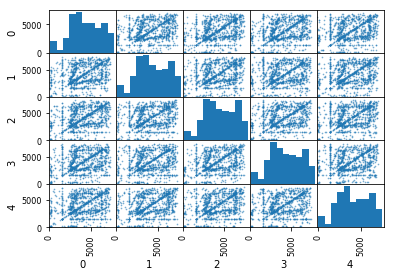

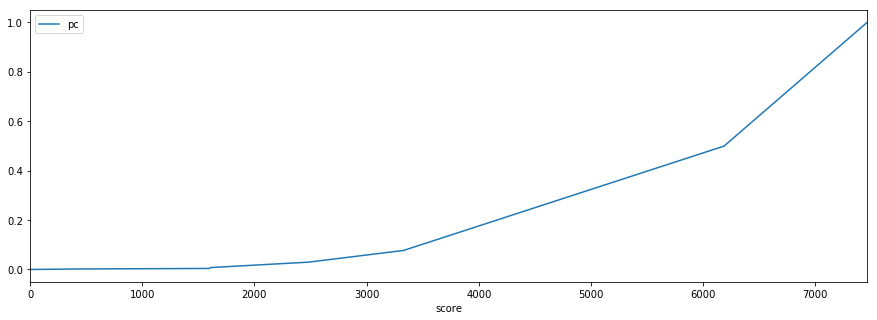

In [125]:
random.seed(0)
_, _, df_scores = build_dataframe(
    nb_hands=1000,
    nb_players=5
)


# All hands to score
from itertools import combinations

deck = Deck().draw(52)
e = Evaluator()
all_hands = [ list(x) for x in combinations(deck, 5) ]
all_scores = [ e.evaluate(x, []) for x in all_hands ]

s = pd.Series(all_scores)
s = s.sort_values().reset_index(drop=True)
df = s.to_frame('score')

LENGTH = len(df)
df['pc'] = (1.0 + df.index)/LENGTH
df = df.drop_duplicates('score', keep='last')
df = df.set_index('score')

def score_to_pc(score):
    return df.ix[score, 0]

df_scores.columns = df_scores.columns.get_level_values(1)

df_opponents = pd.concat(
    [
        df_scores[[0]],
        df_scores[[1]].min(axis=1),
        df_scores[[1, 2]].min(axis=1),
        df_scores[[1, 2, 3]].min(axis=1),
        df_scores[[1, 2, 3, 4]].min(axis=1)
    ],
    axis = 1,
    keys = range(5)
)
df_opponents.columns = df_opponents.columns.get_level_values(0)


ax = pd.scatter_matrix(df_scores, s=2)
for i, row in enumerate(ax):
    for j, item in enumerate(row):
        if i != j:
            item.set_xlim(0, 8000)
            item.set_ylim(0, 8000)

df.plot(figsize=(15,5))

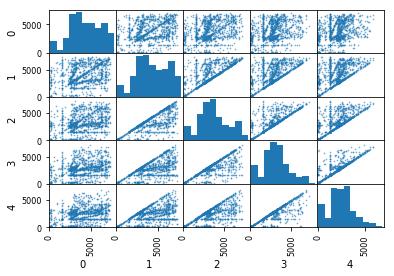

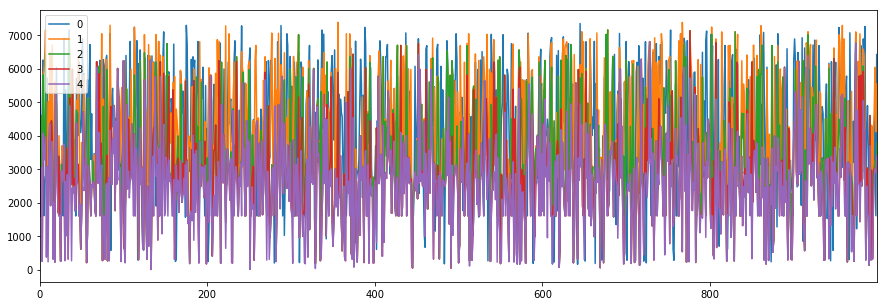

In [126]:
ax = pd.scatter_matrix(df_opponents, s=2)
for i, row in enumerate(ax):
    for j, item in enumerate(row):
        if i != j:
            item.set_xlim(0, 8000)
            item.set_ylim(0, 8000)
df_opponents.plot(figsize=(15,5))

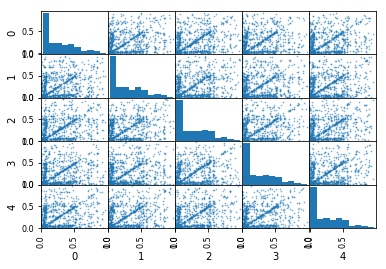

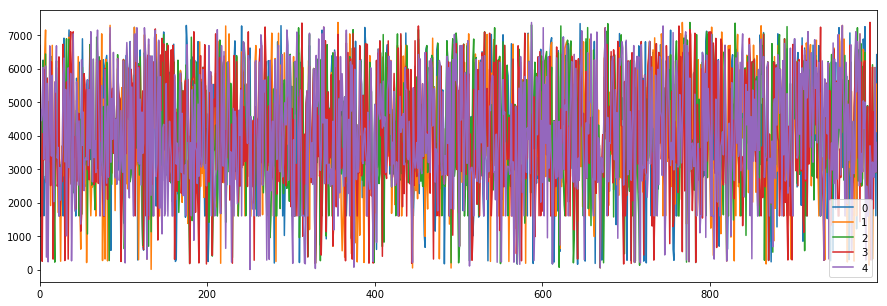

In [127]:
df_pc = df_scores.applymap(score_to_pc)
ax = pd.scatter_matrix(df_pc, s=2)
for i, row in enumerate(ax):
    for j, item in enumerate(row):
        if i != j:
            item.set_xlim(0, 1.0)
            item.set_ylim(0, 1.0)
df_scores.plot(figsize=(15,5))

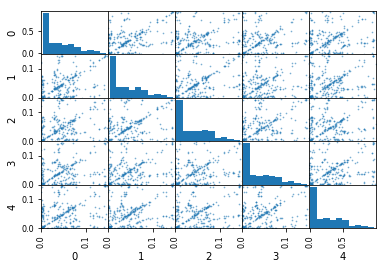

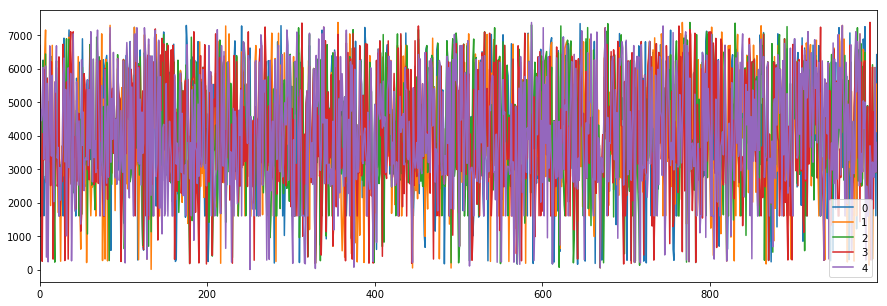

In [128]:
df_pc = df_scores.applymap(score_to_pc)
ax = pd.scatter_matrix(df_pc, s=2)
for i, row in enumerate(ax):
    for j, item in enumerate(row):
        if i != j:
            item.set_xlim(0, 0.15)
            item.set_ylim(0, 0.15)
df_scores.plot(figsize=(15,5))

In [129]:
# scatter plots
random.seed(0)
def deal_cards(nb_players=2):
    all_cards = [ Deck().draw(5 + 2*nb_players) for x in range(10000) ]
    df = pd.DataFrame({'all': all_cards})
    df['board'] = df['all'].apply(lambda x: x[:5])
    for i in range(nb_players):
        i_start = 5 + 2*i
        i_end = i_start + 2
        df['player{0}'.format(i+1)] = df['all'].apply(lambda x: list(islice(x, i_start, i_end)))
    del df['all']
    return df

df = deal_cards(3)
evaluator = Evaluator()
df['score1'] = df.apply(lambda x: evaluator.evaluate(x['board'], x['player1']), axis=1)
df['score2'] = df.apply(lambda x: evaluator.evaluate(x['board'], x['player2']), axis=1)
df['score3'] = df.apply(lambda x: evaluator.evaluate(x['board'], x['player3']), axis=1)

df['score_min23'] = df[['score2', 'score3']].min(axis=1)


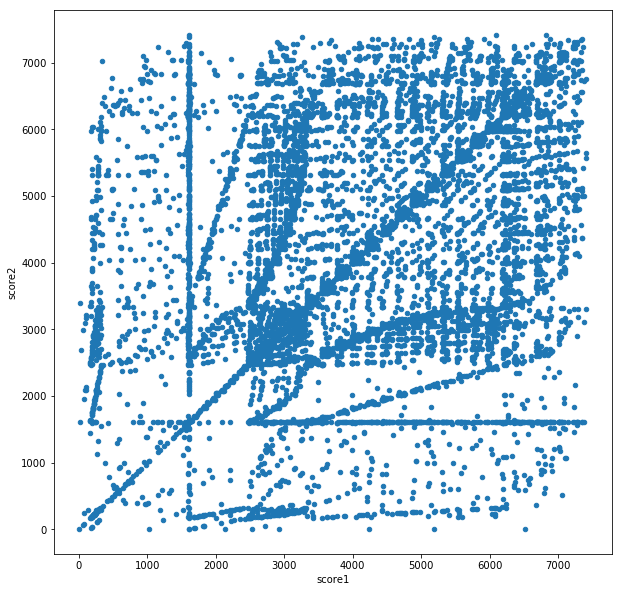

In [130]:
# 2_hand_scatter_full
df.plot.scatter(x='score1', y='score2', figsize=(10,10))

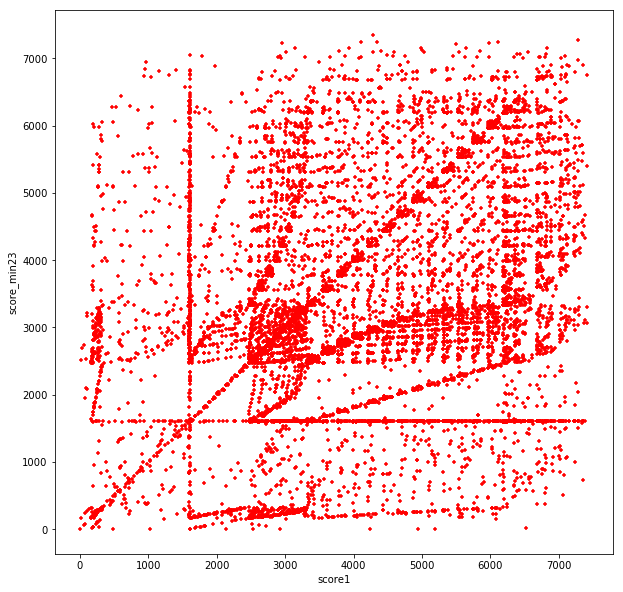

In [131]:
# 3_hand_scatter_full
df.plot.scatter(x='score1', y='score_min23', color='Red', marker='+',figsize=(10,10))

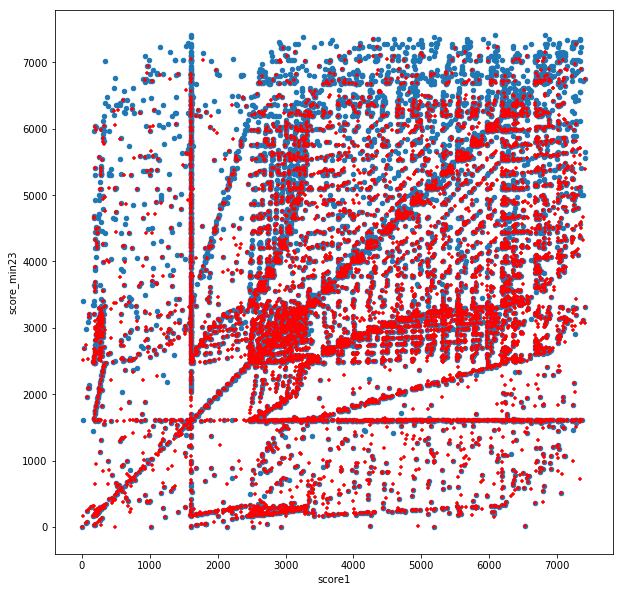

In [132]:
# 2+3_hand_scatter_full
ax2 = df.plot.scatter(x='score1', y='score2', figsize=(15,5))
df.plot.scatter(x='score1', y='score_min23', color='Red', marker='+', ax=ax2, figsize=(10,10))

In [133]:
hands = df[(df.score1 > 3325) & (df.score2 > 3325) & (df.score3 > 3325)]
#print(hands)